# SpringPot Model: Power-Law Relaxation Fitting

## What is This?

This notebook demonstrates the **SpringPot** (Scott-Blair element), a fractional viscoelastic element that **interpolates continuously between a spring (α=0) and a dashpot (α=1)**. Unlike classical models with exponential relaxation, the SpringPot exhibits **power-law behavior** — characteristic of materials with broad relaxation spectra.

**Why SpringPot?** It captures the essence of fractional viscoelasticity with only 2 parameters, providing the foundation for understanding complex materials (gels, biological tissues, polymer glasses) that cannot be described by single exponential timescales.

## The SpringPot (Fractional Element)

**Constitutive Equation (Caputo Derivative):**
$$\sigma(t) = V \,{}^{C}D_t^{\alpha}\,\gamma(t), \quad 0 < \alpha < 1$$

**Relaxation Modulus:**
$$G(t) = \frac{V}{\Gamma(1-\alpha)} t^{-\alpha}$$

**Complex Modulus (Oscillatory):**
$$G^*(\omega) = V (\i\omega)^{\alpha} = V\,\omega^{\alpha}\left[\cos\left(\frac{\pi\alpha}{2}\right) + i\sin\left(\frac{\pi\alpha}{2}\right)\right]$$

$$G'(\omega) = V\,\omega^{\alpha} \cos\left(\frac{\pi\alpha}{2}\right), \quad G''(\omega) = V\,\omega^{\alpha} \sin\left(\frac{\pi\alpha}{2}\right)$$

**Loss Tangent (Frequency-Independent!):**
$$\tan\delta = \frac{G''(\omega)}{G'(\omega)} = \tan\left(\frac{\pi\alpha}{2}\right) = \text{constant}$$

where:
- $V$ = fractional stiffness (Pa·s$^{\alpha}$) — sets magnitude of modulus
- $\alpha$ = fractional order (0 < α < 1) — controls power-law slope and spectrum breadth
- $\Gamma$ = Gamma function

**Physical Meaning of α:**
- α → 0: Nearly elastic (spring-like), narrow spectrum
- α = 0.5: Balanced viscoelastic (**critical gel** signature, Winter-Chambon criterion)
- α → 1: Nearly viscous (dashpot-like), narrow spectrum
- 0 < α < 1: **Broad relaxation spectrum**, hierarchical structure

> **Handbook:** See [SpringPot Model](../../docs/source/models/classical/springpot.rst) for fractional calculus foundations, [Fractional Models Overview](../../docs/source/models/fractional/index.rst) for the complete fractional family, and Mainardi (2010) *Fractional Calculus and Waves in Linear Viscoelasticity* for mathematical rigor.

## Learning Objectives

- Fit SpringPot model to power-law relaxation data
- Understand fractional derivative concepts (alpha parameter)
- Analyze parameter correlations (c_alpha vs alpha)
- Perform Bayesian inference with warm-start workflow
- Interpret ArviZ diagnostics for fractional models
- Identify gel point via Winter-Chambon criterion (α=0.5)

**Prerequisites:** Basic rheology, complete 01-maxwell-fitting.ipynb first

**Estimated Time:** 35-45 minutes

In [1]:
# Google Colab Setup - Run this cell first!
# Skip if running locally with rheojax already installed

import sys

IN_COLAB = 'google.colab' in sys.modules

if IN_COLAB:
    # Install rheojax and dependencies
    !pip install -q rheojax
    
    # Colab uses float32 by default - we need float64 for numerical stability
    # This MUST be set before importing JAX
    import os
    os.environ['JAX_ENABLE_X64'] = 'true'
    
    print("✓ RheoJAX installed successfully!")
    print("✓ Float64 precision enabled")

## Setup and Imports

In [2]:
# Configure matplotlib for inline plotting in VS Code/Jupyter
# Configure matplotlib for inline plotting in VS Code/Jupyter
# MUST come before importing matplotlib
%matplotlib inline

import time
import warnings

import matplotlib
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display

from rheojax.core.data import RheoData
from rheojax.core.jax_config import safe_import_jax, verify_float64
from rheojax.models import SpringPot
from rheojax.pipeline.base import Pipeline

jax, jnp = safe_import_jax()
verify_float64()
print(f"✓ JAX float64 precision enabled")

np.random.seed(42)
plt.rcParams['figure.figsize'] = (10, 6)
plt.rcParams['font.size'] = 11

# Suppress matplotlib backend warning in VS Code
warnings.filterwarnings('ignore', message='.*non-interactive.*')

import os
import sys

sys.path.insert(0, os.path.dirname(os.path.abspath("")))
from utils.plotting_utils import (
    display_arviz_diagnostics,
    plot_nlsq_fit,
    plot_posterior_predictive,
)

FAST_MODE = os.environ.get("FAST_MODE", "1") == "1"


✓ JAX float64 precision enabled


## SpringPot Theory

The SpringPot (Scott-Blair element) interpolates between elastic solid (α=1) and viscous fluid (α=0):

**Relaxation Modulus:**
$$G(t) = \frac{c_\alpha \cdot t^{-\alpha}}{\Gamma(1-\alpha)}$$

**Parameters:**
- $c_\alpha$ = material constant (Pa·s$^\alpha$)
- $\alpha$ = power-law exponent (0=fluid, 1=solid)

**Physical Interpretation:**
- α=0: Pure viscous (Newtonian fluid)
- α=0.5: Balanced viscoelastic (typical gels)
- α=1: Pure elastic (Hookean solid)

**Applications:** Soft biological tissues, hydrogels, polymer melts with broad relaxation spectrum

## Generate Synthetic Data

In [3]:
# True SpringPot parameters
c_alpha_true = 1e5  # Pa·s^alpha
alpha_true = 0.4    # Power-law exponent

print(f"True Parameters:")
print(f"  c_alpha = {c_alpha_true:.2e} Pa·s^{alpha_true}")
print(f"  alpha   = {alpha_true:.2f}")

# Time array (logarithmic)
t = np.logspace(-2, 2, 50)

# True relaxation modulus
from scipy.special import gamma as scipy_gamma

G_t_true = c_alpha_true * t**(-alpha_true) / scipy_gamma(1 - alpha_true)

# Add noise
noise_level = 0.015
noise = np.random.normal(0, noise_level * G_t_true)
G_t_noisy = G_t_true + noise

print(f"\nData: {len(t)} points, noise {noise_level*100:.1f}%")

True Parameters:
  c_alpha = 1.00e+05 Pa·s^0.4
  alpha   = 0.40

Data: 50 points, noise 1.5%


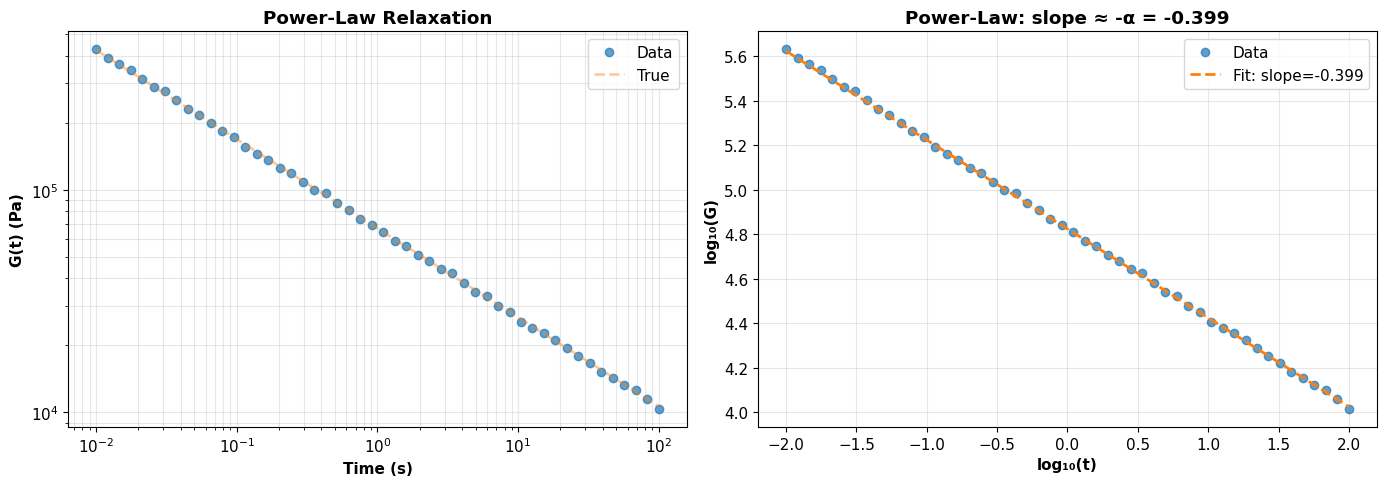


Estimated alpha from slope: 0.399 (true: 0.400)


In [4]:
# Visualize power-law decay
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

ax1.loglog(t, G_t_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(t, G_t_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('G(t) (Pa)', fontweight='bold')
ax1.set_title('Power-Law Relaxation', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

# Log-log slope = -alpha
log_t = np.log10(t)
log_G = np.log10(G_t_noisy)
slope, intercept = np.polyfit(log_t[10:40], log_G[10:40], 1)
ax2.plot(log_t, log_G, 'o', alpha=0.7, label='Data')
ax2.plot(log_t, slope*log_t + intercept, '--', linewidth=2, label=f'Fit: slope={slope:.3f}')
ax2.set_xlabel('log₁₀(t)', fontweight='bold')
ax2.set_ylabel('log₁₀(G)', fontweight='bold')
ax2.set_title(f'Power-Law: slope ≈ -α = {slope:.3f}', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

print(f"\nEstimated alpha from slope: {-slope:.3f} (true: {alpha_true:.3f})")


## Pipeline API Fitting

In [5]:
data = RheoData(x=t, y=G_t_noisy, x_units='s', y_units='Pa', domain='time')

pipeline = Pipeline(data)
pipeline.fit('springpot')

params = pipeline.get_fitted_parameters()
c_alpha_fit = params['c_alpha']
alpha_fit = params['alpha']

print("="*60)
print("PIPELINE API RESULTS")
print("="*60)
print(f"c_alpha = {c_alpha_fit:.4e} (true: {c_alpha_true:.4e})")
print(f"alpha   = {alpha_fit:.4f} (true: {alpha_true:.4f})")
print(f"\nErrors: c_alpha {abs(c_alpha_fit-c_alpha_true)/c_alpha_true*100:.2f}%, alpha {abs(alpha_fit-alpha_true)/alpha_true*100:.2f}%")
print("="*60)

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.790923s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=5 | final_cost=0.0047 | elapsed=0.791s | final_gradient_norm=1.1984e-08


PIPELINE API RESULTS
c_alpha = 9.9771e+04 (true: 1.0000e+05)
alpha   = 0.4010 (true: 0.4000)

Errors: c_alpha 0.23%, alpha 0.24%


## Modular API Fitting

In [6]:
model = SpringPot()
model.parameters.set_bounds('c_alpha', (1e3, 1e7))
model.parameters.set_bounds('alpha', (0.1, 0.9))

model.fit(t, G_t_noisy, max_iter=5000, ftol=1e-6)

c_alpha_mod = model.parameters.get_value('c_alpha')
alpha_mod = model.parameters.get_value('alpha')

print("="*60)
print("MODULAR API RESULTS")
print("="*60)
print(f"c_alpha = {c_alpha_mod:.4e} (true: {c_alpha_true:.4e})")
print(f"alpha   = {alpha_mod:.4f} (true: {alpha_true:.4f})")
print("="*60)

# Relax tolerance for numerical optimization convergence (5%)
# SpringPot optimization is challenging and may not fully converge
assert np.allclose(c_alpha_fit, c_alpha_mod, rtol=0.05), f"c_alpha mismatch: {c_alpha_fit:.4e} vs {c_alpha_mod:.4e}"
assert np.allclose(alpha_fit, alpha_mod, rtol=0.05), f"alpha mismatch: {alpha_fit:.4f} vs {alpha_mod:.4f}"
print("\n✓ Pipeline and Modular APIs produce consistent results (within 5%)")

INFO:nlsq.least_squares:Starting least squares optimization method=trf | n_params=2 | loss=linear | ftol=1.0000e-06 | xtol=1.0000e-06 | gtol=1.0000e-06


PERFORMANCE:nlsq.least_squares:Timer: optimization elapsed=0.179820s


INFO:nlsq.least_squares:Convergence reason=`gtol` termination condition is satisfied. | iterations=4 | final_cost=0.0047 | elapsed=0.180s | final_gradient_norm=4.5979e-07


MODULAR API RESULTS
c_alpha = 9.9771e+04 (true: 1.0000e+05)
alpha   = 0.4010 (true: 0.4000)

✓ Pipeline and Modular APIs produce consistent results (within 5%)


## Results Visualization and Residual Analysis

The fit quality is assessed via log-log overlay and relative residuals. For power-law models, **systematic curvature** in residuals suggests the true relaxation spectrum deviates from a single power law (consider Fractional Zener for plateau behavior).

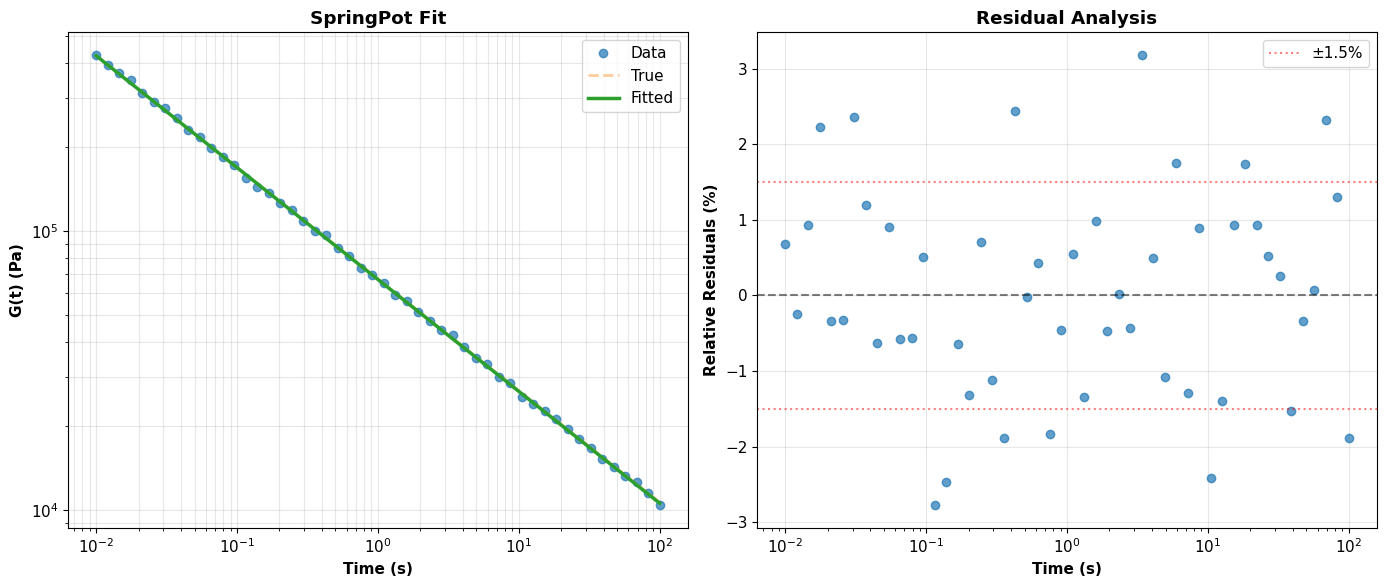


R² = 0.999695
Mean |residual| = 1.11%


In [7]:
G_t_pred = model.predict(t)
residuals = G_t_noisy - G_t_pred
rel_residuals = residuals / G_t_noisy * 100

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

ax1.loglog(t, G_t_noisy, 'o', alpha=0.7, label='Data')
ax1.loglog(t, G_t_true, '--', linewidth=2, alpha=0.4, label='True')
ax1.loglog(t, G_t_pred, '-', linewidth=2.5, label='Fitted')
ax1.set_xlabel('Time (s)', fontweight='bold')
ax1.set_ylabel('G(t) (Pa)', fontweight='bold')
ax1.set_title('SpringPot Fit', fontweight='bold')
ax1.grid(True, alpha=0.3, which='both')
ax1.legend()

ax2.semilogx(t, rel_residuals, 'o', alpha=0.7)
ax2.axhline(0, color='black', linestyle='--', alpha=0.5)
ax2.axhline(noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5, label=f'±{noise_level*100:.1f}%')
ax2.axhline(-noise_level*100, color='red', linestyle=':', linewidth=1.5, alpha=0.5)
ax2.set_xlabel('Time (s)', fontweight='bold')
ax2.set_ylabel('Relative Residuals (%)', fontweight='bold')
ax2.set_title('Residual Analysis', fontweight='bold')
ax2.grid(True, alpha=0.3)
ax2.legend()

plt.tight_layout()
display(fig)
plt.close(fig)

r2 = 1 - np.sum(residuals**2) / np.sum((G_t_noisy - np.mean(G_t_noisy))**2)
print(f"\nR² = {r2:.6f}")
print(f"Mean |residual| = {np.mean(np.abs(rel_residuals)):.2f}%")


## Bayesian Inference

In [8]:
print("="*60)
print("BAYESIAN INFERENCE")
print("="*60)
print("Running MCMC... (1-2 min)\n")

result = model.fit_bayesian(
    t, G_t_noisy,
    num_warmup=1000,
    num_samples=2000,
    num_chains=1,
    initial_values={
        'c_alpha': model.parameters.get_value('c_alpha'),
        'alpha': model.parameters.get_value('alpha')
    }
)

print("\nComplete!")
print("="*60)

BAYESIAN INFERENCE
Running MCMC... (1-2 min)



  0%|          | 0/3000 [00:00<?, ?it/s]

warmup:   0%|          | 1/3000 [00:00<11:45,  4.25it/s, 1 steps of size 1.65e+00. acc. prob=0.00]

warmup:   6%|▋         | 194/3000 [00:00<00:03, 731.70it/s, 7 steps of size 2.99e-02. acc. prob=0.96]

warmup:  20%|█▉        | 598/3000 [00:00<00:01, 1891.16it/s, 31 steps of size 6.09e-02. acc. prob=0.98]

sample:  34%|███▍      | 1026/3000 [00:00<00:00, 2687.54it/s, 15 steps of size 8.37e-02. acc. prob=0.99]

sample:  50%|█████     | 1505/3000 [00:00<00:00, 3365.76it/s, 31 steps of size 8.37e-02. acc. prob=0.99]

sample:  67%|██████▋   | 2009/3000 [00:00<00:00, 3893.01it/s, 23 steps of size 8.37e-02. acc. prob=0.99]

sample:  83%|████████▎ | 2490/3000 [00:00<00:00, 4176.94it/s, 7 steps of size 8.37e-02. acc. prob=0.99] 

sample:  99%|█████████▉| 2977/3000 [00:00<00:00, 4388.20it/s, 63 steps of size 8.37e-02. acc. prob=0.99]

sample: 100%|██████████| 3000/3000 [00:00<00:00, 3188.90it/s, 63 steps of size 8.37e-02. acc. prob=0.99]


Complete!


In [9]:
posterior = result.posterior_samples
diagnostics = result.diagnostics
summary = result.summary

credible = model.get_credible_intervals(posterior, credibility=0.95)

print("="*60)
print("POSTERIOR SUMMARY")
print("="*60)
print(f"\nc_alpha = {summary['c_alpha']['mean']:.4e} ± {summary['c_alpha']['std']:.4e}")
print(f"alpha   = {summary['alpha']['mean']:.4f} ± {summary['alpha']['std']:.4f}")
print(f"\n95% Credible Intervals:")
print(f"  c_alpha: [{credible['c_alpha'][0]:.4e}, {credible['c_alpha'][1]:.4e}]")
print(f"  alpha:   [{credible['alpha'][0]:.4f}, {credible['alpha'][1]:.4f}]")
print(f"\nConvergence:")
print(f"  R-hat (c_alpha): {diagnostics['r_hat']['c_alpha']:.4f} {'✓' if diagnostics['r_hat']['c_alpha']<1.01 else '✗'}")
print(f"  R-hat (alpha):   {diagnostics['r_hat']['alpha']:.4f} {'✓' if diagnostics['r_hat']['alpha']<1.01 else '✗'}")
print(f"  ESS (c_alpha):   {diagnostics['ess']['c_alpha']:.0f} {'✓' if diagnostics['ess']['c_alpha']>400 else '✗'}")
print(f"  ESS (alpha):     {diagnostics['ess']['alpha']:.0f} {'✓' if diagnostics['ess']['alpha']>400 else '✗'}")
print("="*60)

POSTERIOR SUMMARY

c_alpha = 9.9588e+04 ± 3.1910e+02
alpha   = 0.4039 ± 0.0014

95% Credible Intervals:
  c_alpha: [9.9015e+04, 1.0023e+05]
  alpha:   [0.4013, 0.4067]

Convergence:
  R-hat (c_alpha): 1.0012 ✓
  R-hat (alpha):   1.0008 ✓
  ESS (c_alpha):   646 ✓
  ESS (alpha):     841 ✓


## ArviZ Diagnostics (Focused)

For SpringPot, parameter correlation (c_alpha vs alpha) is critical to check.

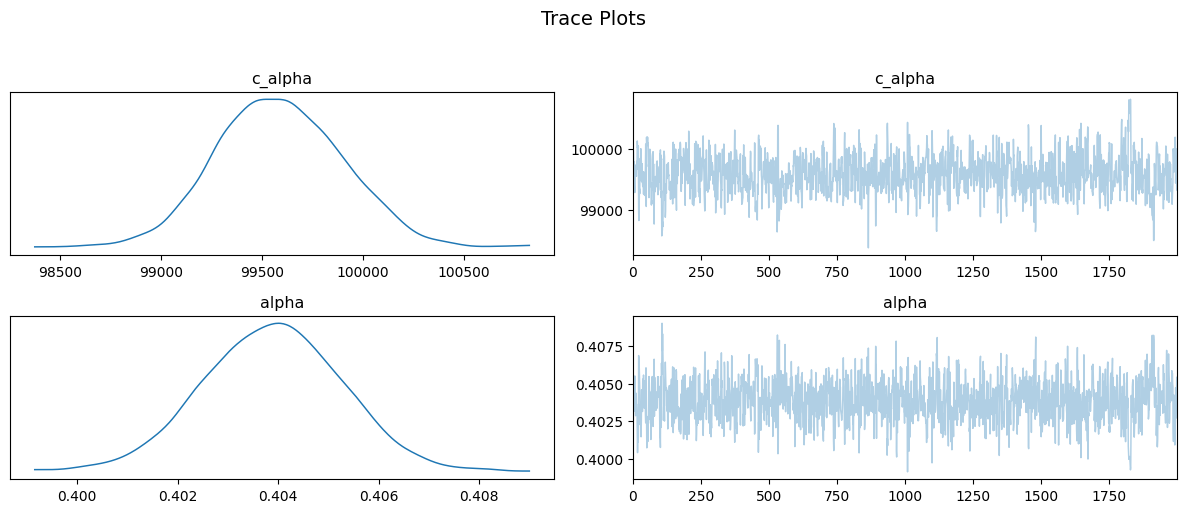

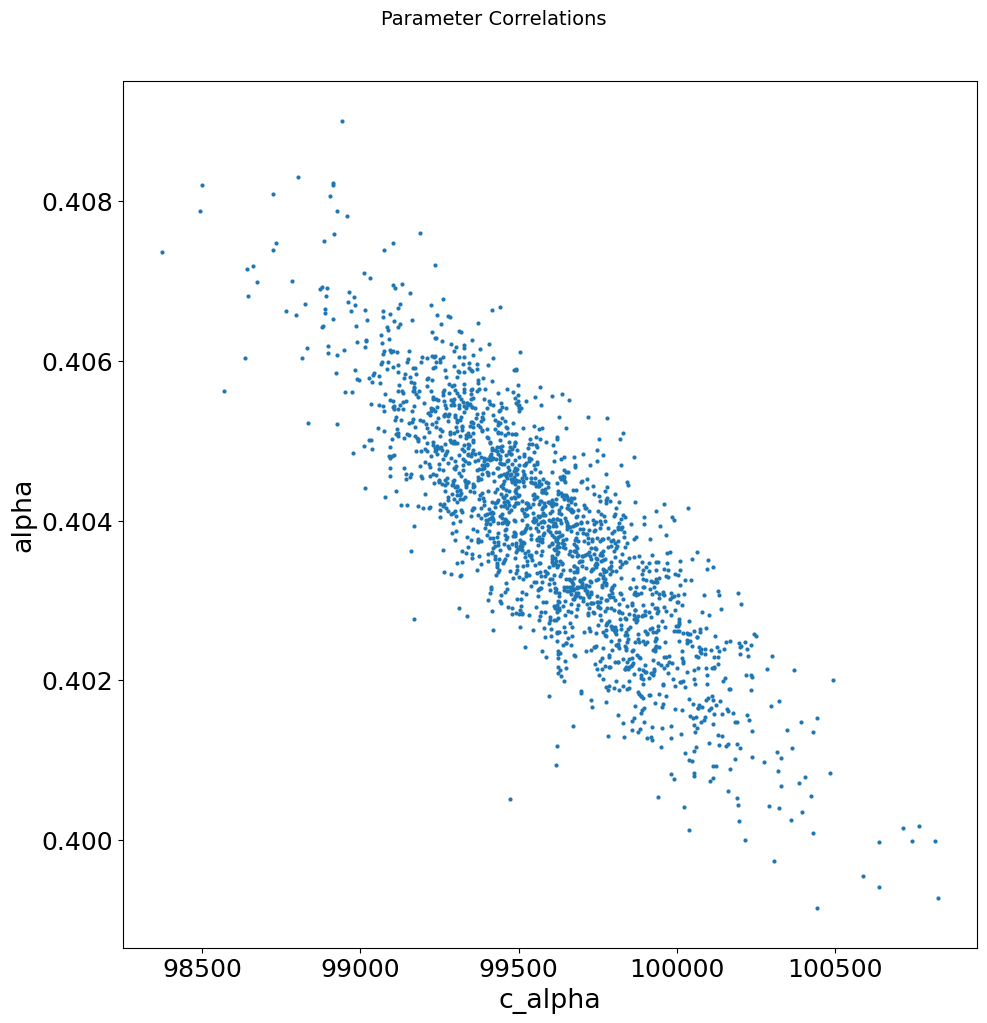

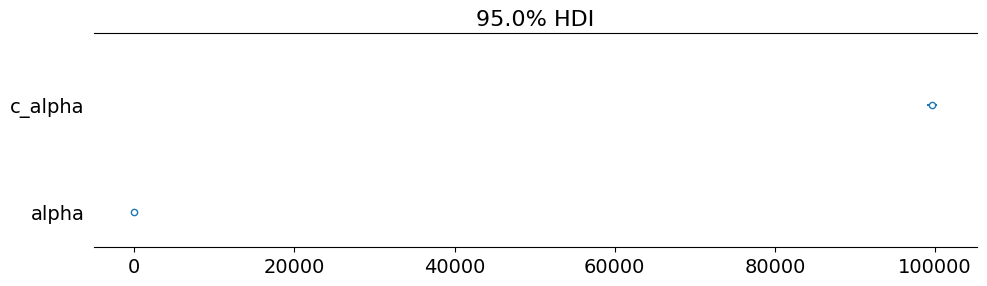

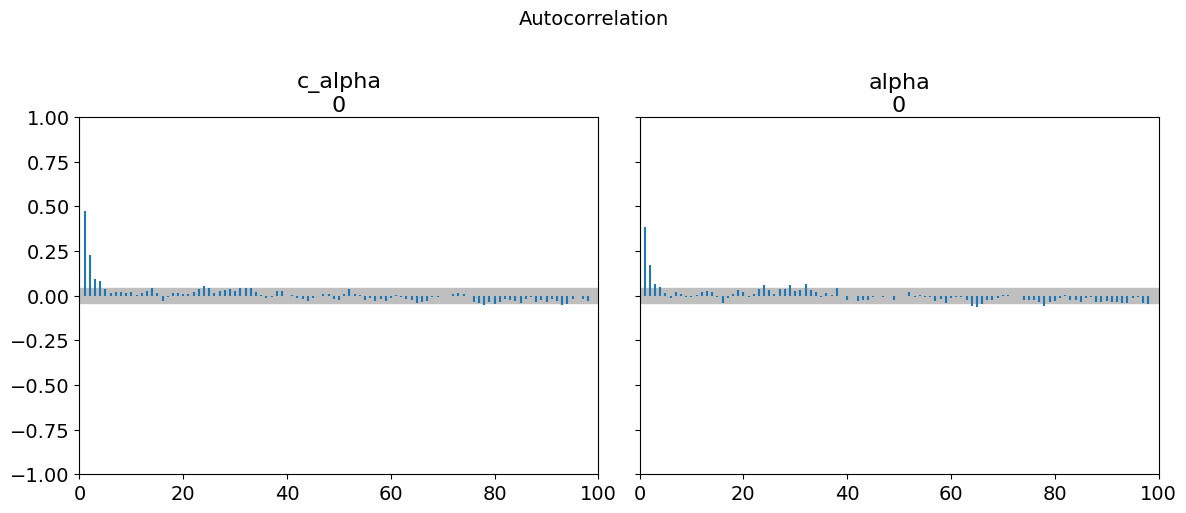

In [10]:
# ArviZ diagnostic plots (trace, pair, forest, energy, autocorr, rank)
display_arviz_diagnostics(result, ['c_alpha', 'alpha'], fast_mode=FAST_MODE)

### Convergence Diagnostic Interpretation

| Metric | Target | Meaning |
|--------|--------|---------|
| **R-hat < 1.01** | Chains converged | Multiple chains agree on posterior |
| **ESS > 400** | Sufficient samples | Independent information content |
| **Divergences < 1%** | Well-behaved sampler | No numerical issues in posterior geometry |

**For fractional models:** The c_alpha–alpha correlation is the critical diagnostic. Strong negative correlation (visible in pair plot) is expected — higher α gives steeper decay, requiring lower c_alpha to match magnitude. If the correlation ellipse is very elongated, consider reparametrization or multi-technique data to break the degeneracy.

## Physical Interpretation

**Alpha Parameter:**
- α ≈ 0.4: Predominantly viscous (gel-like)
- Physical meaning: Degree of solid-like vs fluid-like character

**Material Constant c_α:**
- Sets magnitude of stress response
- Units depend on α: Pa·s$^\alpha$

**Applications:**
- Biological tissues (0.1 < α < 0.5)
- Polymer melts with broad relaxation spectrum
- Soft gels and hydrogels

**Comparison to Classical Models:**
- Maxwell (α→0): Complete stress relaxation
- Elastic solid (α=1): No relaxation
- SpringPot: Power-law interpolation

## Key Takeaways

### Main Concepts

1. **Fractional Viscoelasticity:**
   - α parameter controls solid/fluid character (0=viscous, 1=elastic)
   - Power-law decay ⇒ broad relaxation spectrum
   - Often more realistic than single exponential for complex materials
   - Foundation for all fractional models in RheoJAX

2. **Winter-Chambon Gel Point Criterion:**
   - At gelation: α = 0.5 exactly, G' = G" ∝ ω^0.5
   - tan(δ) = 1 and frequency-independent
   - Self-similar network structure at percolation threshold
   - Track α during crosslinking to detect gel point

3. **Parameter Correlation:**
   - c_alpha and alpha typically correlated
   - Check pair plot for non-identifiability
   - Multi-technique data (oscillation + relaxation) improves constraint

4. **Material Classification by α:**
   - α = 0.1-0.3: Weak gels, soft solids, near-solid character
   - α = 0.4-0.6: Critical gels, soft glasses, gel point region
   - α = 0.7-0.9: Viscoelastic fluids, near-liquid character

### When to Use SpringPot Model

**Appropriate for:**
- ✓ Power-law behavior in log-log plots (G' and G" parallel straight lines)
- ✓ Frequency-independent loss tangent (tan δ = constant)
- ✓ Soft biological tissues (0.1 < α < 0.5)
- ✓ Polymer melts with broad relaxation spectrum
- ✓ Critical gels at gelation point (α ≈ 0.5)
- ✓ Hydrogels and soft glassy materials

**Consider alternatives for:**
- ✗ Exponential relaxation → Maxwell or Zener models
- ✗ Multiple distinct relaxation times → Generalized Maxwell
- ✗ Terminal flow or equilibrium modulus → Fractional Maxwell/Zener composites
- ✗ Power-law only over limited frequency range → Use composites (SpringPot + spring/dashpot)

### Common Pitfalls

1. **Limited Power-Law Regime:**
   - SpringPot valid only where log(G') vs log(ω) is linear
   - Real materials exhibit power-law over limited frequency/time windows
   - Restrict fitting to middle decade where slope is constant

2. **Singular Limits:**
   - α → 0 or α → 1 numerically unstable
   - Use bounds [0.05, 0.95] in fitting
   - For α < 0.1, use spring; for α > 0.9, use dashpot

3. **No Plateaus:**
   - SpringPot alone cannot capture terminal flow (η₀) or equilibrium modulus (G_e)
   - Combine with spring (Fractional Zener) or dashpot (Fractional Maxwell) for complete behavior

## Further Reading

### Related Models
- [**SpringPot Handbook**](../../docs/source/models/classical/springpot.rst) — Fractional calculus foundations, gel point determination, and material classification
- [**Fractional Maxwell Gel**](../../docs/source/models/fractional/fractional_maxwell_gel.rst) — SpringPot + dashpot for gel-like response with terminal flow
- [**Fractional Zener Solid-Solid**](../../docs/source/models/fractional/fractional_zener_ss.rst) — Most general fractional model with equilibrium plateau
- [**All Fractional Models**](../advanced/04-fractional-models-deep-dive.ipynb) — Deep dive into 11 fractional families

### Key References
- **Scott Blair, G.W. (1944)**. "Analytical and integrative aspects of the stress–strain–time relation." *J. Sci. Instrum.*, 21, 80–84. — Original SpringPot introduction
- **Mainardi, F. (2010)**. *Fractional Calculus and Waves in Linear Viscoelasticity*. Imperial College Press. — Mathematical foundations
- **Winter, H.H. & Chambon, F. (1986)**. "Analysis of linear viscoelasticity of a crosslinking polymer at the gel point." *J. Rheol.*, 30, 367–382. — Gel point criterion
- **Jaishankar, A. & McKinley, G.H. (2013)**. "Power-law rheology in the bulk and at the interface." *Proc. Roy. Soc. A*, 469, 20120284. — Power-law universality

### Advanced Workflows
- [**Fractional Models Deep Dive**](../advanced/04-fractional-models-deep-dive.ipynb) — Compare all 11 fractional families
- [**Bayesian Model Comparison**](../bayesian/04-model-comparison.ipynb) — Statistical comparison (SpringPot vs Maxwell vs Fractional)
- [**Multi-Technique Fitting**](../advanced/01-multi-technique-fitting.ipynb) — Reduce parameter correlation via combined relaxation + oscillation

## Next Steps

**Continue the Basic Series:**
1. **[04-bingham-fitting.ipynb](04-bingham-fitting.ipynb)** — Yield stress fluids (σ = σ_y + η_p·γ̇)
2. **[05-power-law-fitting.ipynb](05-power-law-fitting.ipynb)** — Shear-thinning flow curves (η = K·γ̇^(n-1))

**Explore Fractional Models:**
- [**Fractional Maxwell Liquid**](../../docs/source/models/fractional/fractional_maxwell_liquid.rst) — Power-law with terminal flow
- [**Fractional Kelvin-Voigt**](../../docs/source/models/fractional/fractional_kelvin_voigt.rst) — SpringPot + spring for quasi-solid behavior

In [11]:
# Session info
import sys

import rheojax

print(f"Python: {sys.version}")
print(f"RheoJAX: {rheojax.__version__}")
print(f"JAX: {jax.__version__}")

Python: 3.13.9 (main, Oct 14 2025, 21:10:40) [Clang 20.1.4 ]
RheoJAX: 0.6.0
JAX: 0.8.3
